<a href="https://colab.research.google.com/github/GurionRamapoguSajeevan/credit-risk-modeling-ML-pipeline/blob/main/Credit_risk_main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# cloning repo from Git
!git clone https://github.com/GurionRamapoguSajeevan/credit-risk-modeling-ML-pipeline.git

%cd credit-risk-modeling-ML-pipeline

# Listing files to confirm
!ls

Cloning into 'credit-risk-modeling-ML-pipeline'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 7.70 KiB | 7.70 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/credit-risk-modeling-ML-pipeline
01_data_eda.ipynb  LICENSE  README.md  requirements.txt


# installing the required dependencies

In [2]:
# Install from requirements (run this)
!pip install -r requirements.txt

# Extra for Colab (if needed)
!pip install --upgrade pandas shap plotly duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.8 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 90.6 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2
  Attempting uninstall: pandas
    Found existing ins

### Loading the data and basic checks

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb  # For SQL-like queries

# Load data
df = pd.read_csv('/content/credit_risk_dataset.csv')
print(f"Shape: {df.shape}")
print("\nColumns:")
print(df.columns.tolist())
print("\nSample:")
display(df.head())

# Quick info
df.info()

Shape: (32581, 12)

Columns:
['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

Sample:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


## Essential Data quality checks

In [5]:
# Missing values
print("Missing Values:")
print(df.isnull().sum())

# Duplicates
print(f"\nDuplicates: {df.duplicated().sum()}")

# Basic stats
display(df.describe())

# Target distribution (imbalance!)
print("\nTarget (loan_status) Distribution:")
print(df['loan_status'].value_counts(normalize=True) * 100)

# SQL Query trial
query = """
SELECT
    loan_status,
    COUNT(*) as count,
    AVG(person_income) as avg_income,
    AVG(loan_amnt) as avg_loan
FROM df
GROUP BY loan_status
"""
print("\nSQL-like Summary:")
display(duckdb.query(query).df())

Missing Values:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Duplicates: 165


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000



Target (loan_status) Distribution:
loan_status
0    78.183604
1    21.816396
Name: proportion, dtype: float64

SQL-like Summary:


,loan_status,count,avg_income,avg_loan
0,0,25473,70804.361559,9237.464178
1,1,7108,49125.652223,10850.502954


## EDA Visuals (Distributions & Correlations)

<Figure size 1500x1000 with 0 Axes>

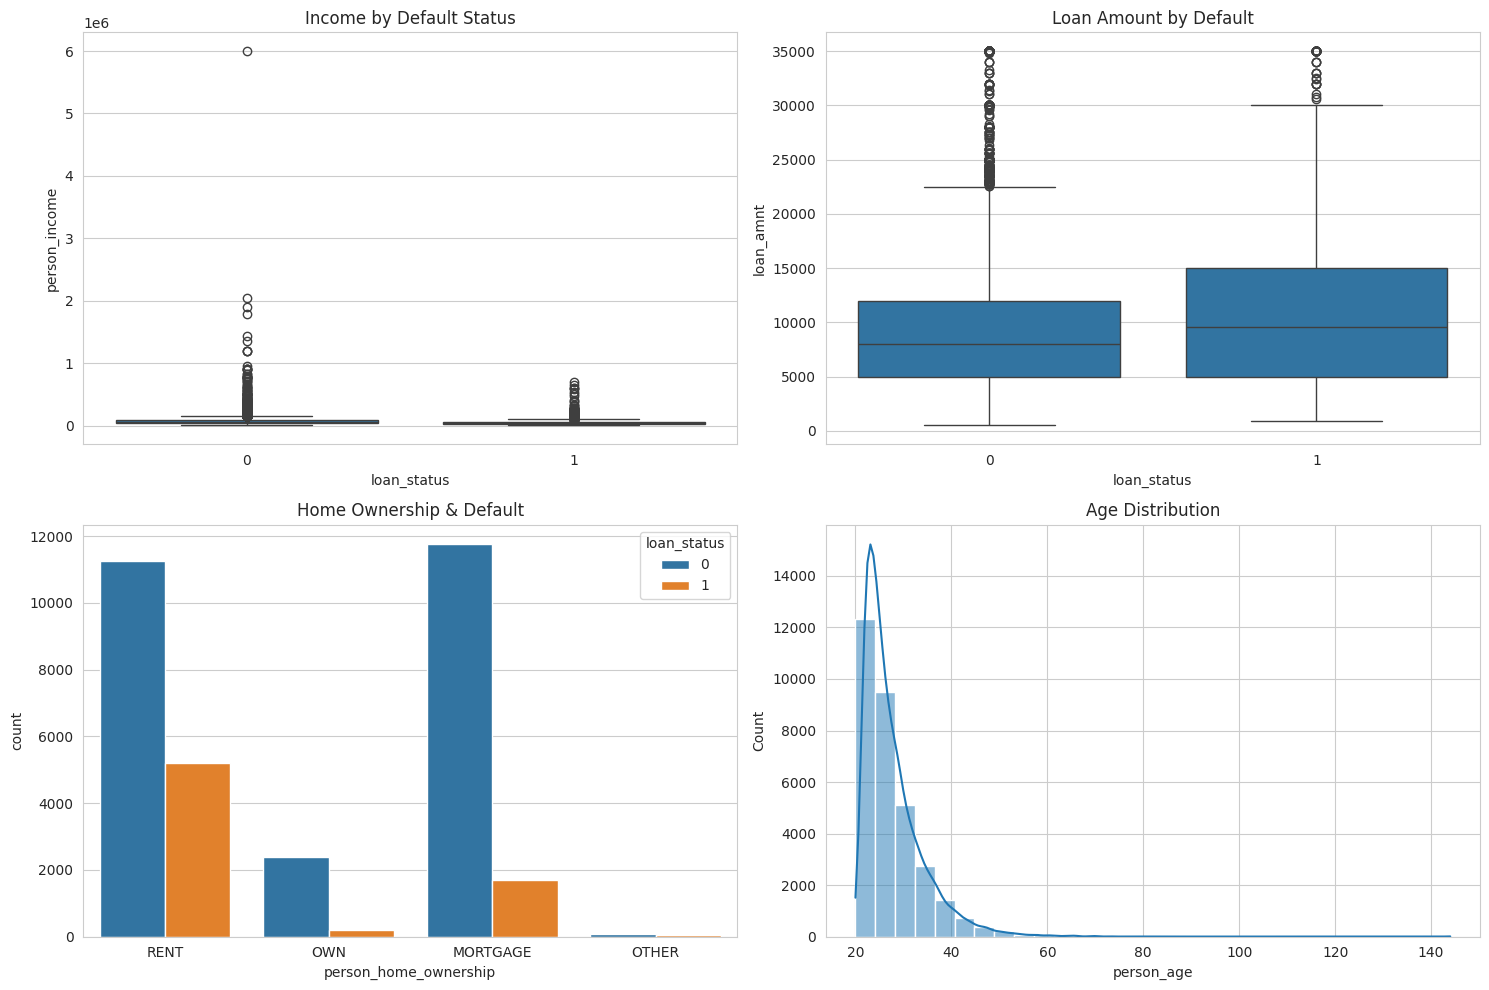

In [6]:
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# 1. Target by Key Features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x='loan_status', y='person_income', data=df, ax=axes[0,0])
axes[0,0].set_title('Income by Default Status')

sns.boxplot(x='loan_status', y='loan_amnt', data=df, ax=axes[0,1])
axes[0,1].set_title('Loan Amount by Default')

sns.countplot(x='person_home_ownership', hue='loan_status', data=df, ax=axes[1,0])
axes[1,0].set_title('Home Ownership & Default')

sns.histplot(df['person_age'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title('Age Distribution')

plt.tight_layout()
plt.show()


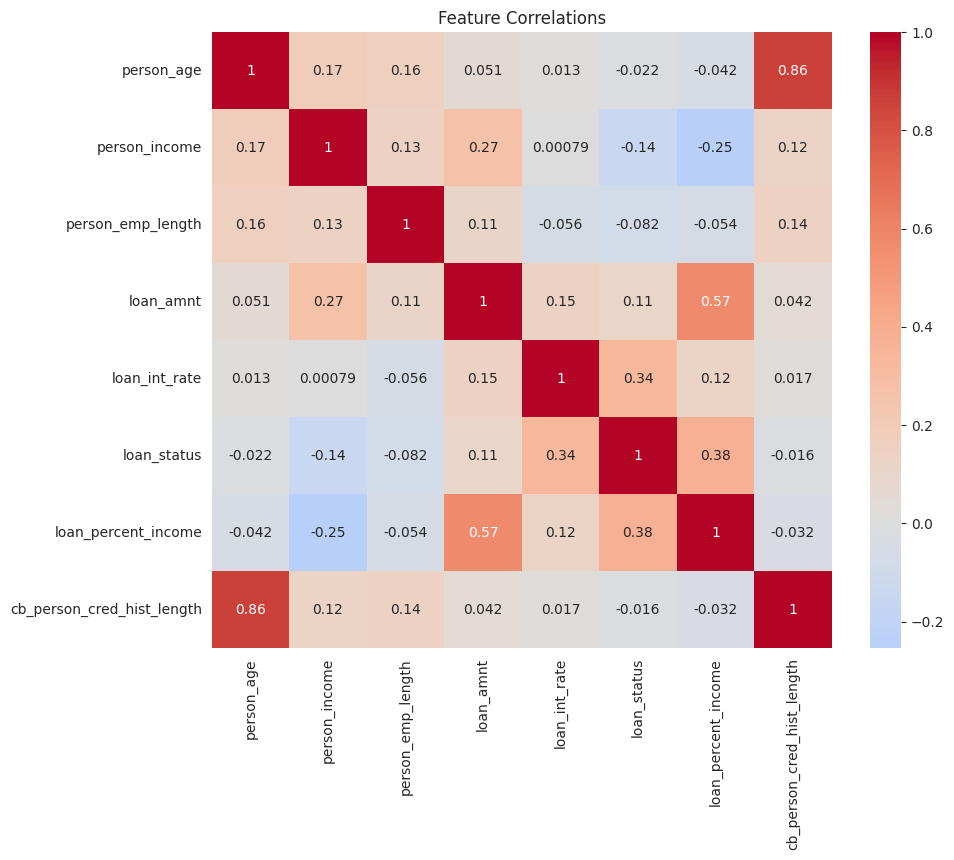

In [8]:
# 2. Correlation Heatmap (numerics)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

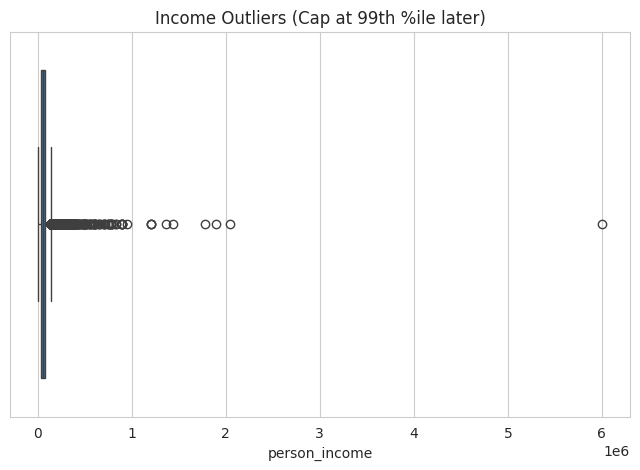

In [7]:
# 3. Outlier Check (Income)
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['person_income'])
plt.title('Income Outliers (Cap at 99th %ile later)')
plt.show()

## Default rates by Key Categories

/tmp/ipython-input-1143774401.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_rates.index, y=default_rates.values, ax=axes[i], palette='viridis')
/tmp/ipython-input-1143774401.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_rates.index, y=default_rates.values, ax=axes[i], palette='viridis')
/tmp/ipython-input-1143774401.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_rates.index, y=default_rates.values, ax=axes[i], palette='viridis')


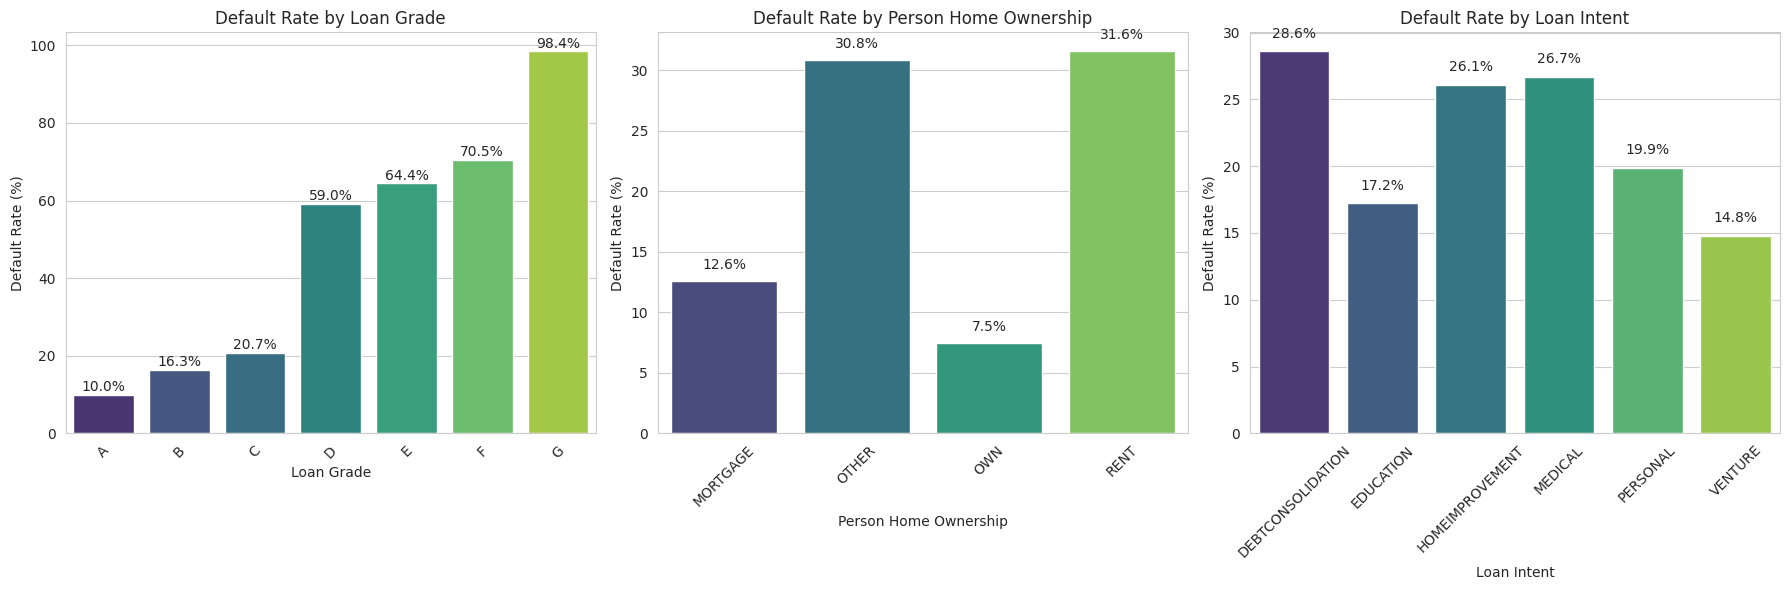

Key Insight: Grade D+ loans have 2-3x default risk—flag for lending decisions.


In [8]:
#4 Default rates by categorical features
cat_features = ['loan_grade', 'person_home_ownership', 'loan_intent']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, col in enumerate(cat_features):
    # Pivot for % default
    default_rates = df.groupby(col)['loan_status'].mean() * 100
    sns.barplot(x=default_rates.index, y=default_rates.values, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Default Rate by {col.replace("_", " ").title()}')
    axes[i].set_ylabel('Default Rate (%)')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].tick_params(axis='x', rotation=45)
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.1f}%', (p.get_x() + 0.4, p.get_height() + 1), ha='center')

plt.tight_layout()
plt.show()

# Insight print
print("Key Insight: Grade D+ loans have 2-3x default risk—flag for lending decisions.")

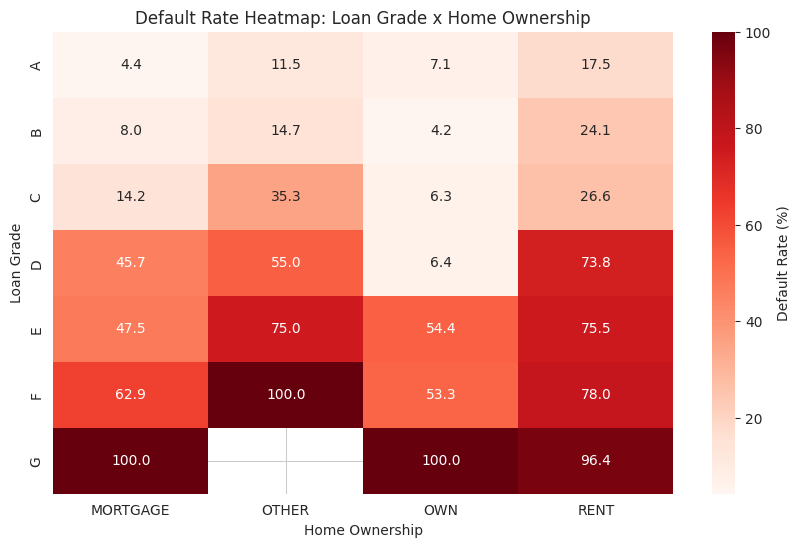


Top Risk Combos (SQL Query):


,loan_grade,person_home_ownership,default_rate,count
0,G,MORTGAGE,100.000000,31
1,G,OWN,100.000000,5
2,F,OTHER,100.000000,2
3,G,RENT,96.428571,28
4,F,RENT,77.952756,127
5,E,RENT,75.535714,560
6,E,OTHER,75.000000,8
7,D,RENT,73.781354,2113
8,F,MORTGAGE,62.886598,97
9,D,OTHER,55.000000,20


In [9]:
# Crosstab: Default rate by Grade x Home Ownership
pivot = pd.pivot_table(
    df,
    values='loan_status',
    index='loan_grade',
    columns='person_home_ownership',
    aggfunc='mean'
) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='Reds', cbar_kws={'label': 'Default Rate (%)'})
plt.title('Default Rate Heatmap: Loan Grade x Home Ownership')
plt.ylabel('Loan Grade')
plt.xlabel('Home Ownership')
plt.show()

# SQL-like for big data feel
query = """
SELECT
    loan_grade,
    person_home_ownership,
    AVG(loan_status) * 100 as default_rate,
    COUNT(*) as count
FROM df
GROUP BY loan_grade, person_home_ownership
ORDER BY default_rate DESC
LIMIT 10
"""
print("\nTop Risk Combos (SQL Query):")
display(duckdb.query(query).df())

## Data Cleaning & Feature Engineering

In [10]:
# 1. Handle Missings (proactive quality)
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

# 2. Cap Outliers (e.g., age >100, income >99th)
df['person_age'] = df['person_age'].clip(upper=df['person_age'].quantile(0.99))
df['person_income'] = df['person_income'].clip(upper=df['person_income'].quantile(0.99))

# 3. New Features (business-relevant)
df['dti_ratio'] = df['loan_amnt'] / df['person_income']  # Debt-to-Income
df['loan_to_income'] = df['loan_amnt'] / df['person_income']
df['emp_to_age'] = df['person_emp_length'] / df['person_age']  # Stability proxy

# 4. Encode Categoricals (one-hot for now)
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Cleaned Shape:", df.shape)
display(df.head(3))

Cleaned Shape: (32581, 26)


/tmp/ipython-input-2347333937.py:7: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['person_income'] = df['person_income'].clip(upper=df['person_income'].quantile(0.99))


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,dti_ratio,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,22,59000,123.0,35000,16.02,1,0.59,Y,3,0.593220,...,False,False,True,False,False,False,True,False,False,False
1,21,9600,5.0,1000,11.14,0,0.10,N,2,0.104167,...,False,False,False,False,True,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,N,3,0.572917,...,False,True,False,False,False,True,False,False,False,False


## saving EDA checkpoint

In [28]:
import os

# 1. Save cleaned data
df.to_csv('credit_risk_cleaned.csv', index=False)
print("✅ Cleaned data saved as credit_risk_cleaned.csv")

✅ Cleaned data saved as credit_risk_cleaned.csv


# MODELING

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report
from sklearn.metrics import auc as compute_auc   # rename at import
import joblib  # For saving models (simple .pkl)

# This is the cleaned data
df = pd.read_csv('credit_risk_cleaned.csv')
print(f"Loaded: {df.shape}")
print("Target distribution:")
print(df['loan_status'].value_counts(normalize=True))

# Features & Target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

Loaded: (32581, 26)
Target distribution:
loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64


## Train/test splitting + Preprocessing

In [ ]:
# print("Data types after cleaning:")
# print(df.dtypes.value_counts())

# print("\nColumns that are still object/string:")
# object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# print(object_cols)

# if object_cols:
#     print("\nSample values from object columns:")
#     for col in object_cols:
#         print(f"{col}: {df[col].unique()[:8]}")

In [38]:
# Safety check
if not df.select_dtypes(include=['object', 'string']).empty:
    print("WARNING: Still have non-numeric columns!")
    print(df.select_dtypes(include=['object', 'string']).columns)
else:
    print("All columns are numeric → good for modeling")

All columns are numeric → good for modeling


In [39]:
# Quick binary encoding for the problematic column
if 'cb_person_default_on_file' in df.columns:
    df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
    print("Encoded cb_person_default_on_file → 1=Y / 0=N")

In [22]:
# # Encode ALL remaining categoricals / strings automatically
# # This catches anything you might have missed, like 'Y'/'N'
# remaining_cats = df.select_dtypes(include=['object', 'category']).columns

# if len(remaining_cats) > 0:
#     print("Encoding remaining categorical columns:", remaining_cats.tolist())
#     df = pd.get_dummies(df, columns=remaining_cats, drop_first=True)
# else:
#     print("No remaining categorical columns")

# # Now verify
# print("Final dtypes:")
# print(df.dtypes.value_counts())

In [24]:
#print(df.head(5))

In [40]:
# Split (80/20, stratified for imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerics (for Logistic)
scaler = StandardScaler()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Handle imbalance (SMOTE for oversampling)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", X_train_res.shape, y_train_res.value_counts(normalize=True))

After SMOTE: (40756, 25) loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


# Training the Models

In [41]:

# 1. Logistic Regression (interpretable baseline)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_res, y_train_res)

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
rf.fit(X_train_res, y_train_res)

# 3. XGBoost (advanced, production-grade)
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)
xgb.fit(X_train_res, y_train_res)

print("✅ All models trained!")

✅ All models trained!


### Evaluate Models (Risk-Focused Metrics)

In [43]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = compute_auc(recall, precision)

    print(f"\n{name} Results:")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f} (key for imbalanced risk)")
    print(classification_report(y_test, y_pred))
    return auc, pr_auc

# Evaluate all
models = {'Logistic Regression': log_reg, 'Random Forest': rf, 'XGBoost': xgb}
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_test, y_test, name)

# Best model (for deployment)
best_model = max(results, key=lambda k: results[k][0])
print(f"\n🏆 Best Model: {best_model}")


Logistic Regression Results:
AUC-ROC: 0.8700
PR-AUC: 0.7226 (key for imbalanced risk)
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      5095
           1       0.56      0.77      0.65      1422

    accuracy                           0.82      6517
   macro avg       0.74      0.80      0.76      6517
weighted avg       0.85      0.82      0.83      6517


Random Forest Results:
AUC-ROC: 0.9202
PR-AUC: 0.8652 (key for imbalanced risk)
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5095
           1       0.82      0.74      0.78      1422

    accuracy                           0.91      6517
   macro avg       0.87      0.85      0.86      6517
weighted avg       0.90      0.91      0.91      6517


XGBoost Results:
AUC-ROC: 0.9343
PR-AUC: 0.8811 (key for imbalanced risk)
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     

## Feature Importance (For Trees) + Saving the Best Model

In [44]:
# Feature Importance (XGBoost example - ties to explainability)
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Features (XGBoost):")
display(importances.head(10))

Top 10 Features (XGBoost):


,Feature,Importance
20,loan_grade_D,0.115557
8,loan_to_income,0.101230
12,person_home_ownership_RENT,0.100817
7,dti_ratio,0.091385
4,loan_int_rate,0.052753
6,cb_person_cred_hist_length,0.051645
21,loan_grade_E,0.051244
19,loan_grade_C,0.043129
11,person_home_ownership_OWN,0.040163
14,loan_intent_HOMEIMPROVEMENT,0.038421


## Confusion Matrix + ROC + PR curves for XGBoost

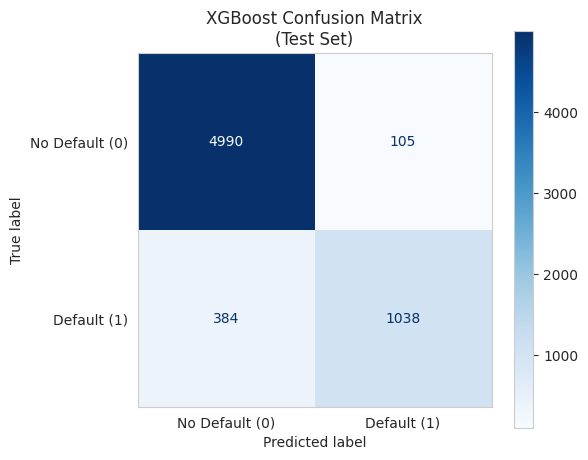

True Negatives (good loans correctly approved): 4990
False Positives (good loans rejected): 105
False Negatives (bad loans approved): 384
True Positives (bad loans correctly rejected): 1038


In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Predictions ─────────────────────────────────────────────────────────
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# ─── 1. Confusion Matrix ─────────────────────────────────────────────────
cm = confusion_matrix(y_test, y_pred_xgb)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Default (0)', 'Default (1)'])
disp.plot(ax=ax, cmap='Blues', values_format='d')

plt.title("XGBoost Confusion Matrix\n(Test Set)")
plt.grid(False)
plt.tight_layout()
plt.show()

# Print counts
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (good loans correctly approved): {tn}")
print(f"False Positives (good loans rejected): {fp}")
print(f"False Negatives (bad loans approved): {fn}")
print(f"True Positives (bad loans correctly rejected): {tp}")



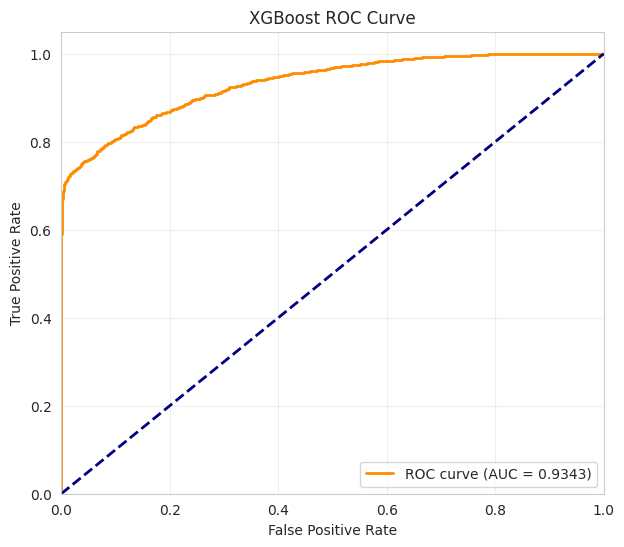

In [54]:
# ─── 2. ROC Curve ────────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = roc_auc_score(y_test, y_prob_xgb)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

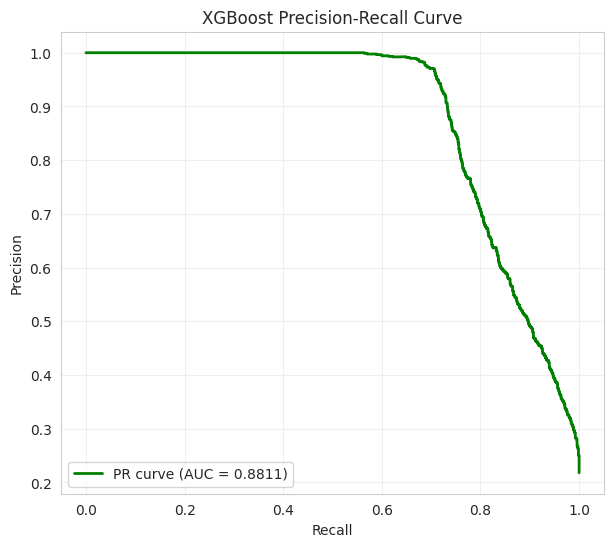

In [59]:
# ─── 3. Precision-Recall Curve ───────────────────────────────────────────
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc = auc(recall, precision)

#pr_auc = np.trapz(precision, recall)   # or use auc(recall, precision) if not shadowed

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color='green', lw=2,
         label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

In [45]:
# Save best model (XGBoost) as .pkl (for Streamlit later - download it)
joblib.dump(xgb, 'xgboost_credit_risk_model.pkl')
print("✅ Model saved as xgboost_credit_risk_model.pkl (download via Files pane)")

# Optional: Save scaler too
joblib.dump(scaler, 'scaler.pkl')

✅ Model saved as xgboost_credit_risk_model.pkl (download via Files pane)


['scaler.pkl']

Key takeaways:

- XGBoost is significantly better at separating good vs. bad loans (highest AUC-ROC and PR-AUC).
- Very high precision on defaults (91%) means low false alarm rate → important for credit decisions (avoid rejecting good applicants).
- Recall on defaults (73%) is reasonable but leaves room for tuning if the business prioritizes catching more defaults (e.g., adjust probability threshold or class weights).
- Overall, this level of performance (AUC > 0.93) is competitive with many real-world credit risk models.

Top Features (XGBoost) – Business Interpretation
These are the most influential drivers of default risk according to the model:

- loan_grade_D (0.116)
→ Loans rated "D" have dramatically higher default probability (very strong signal).
- loan_to_income (0.101)
→ How large the loan is relative to income — classic affordability risk factor.
- person_home_ownership_RENT (0.101)
→ Renters default more often than owners/mortgage holders (proxy for financial stability).
- dti_ratio (0.091)
→ Debt-to-income ratio — another core affordability / repayment capacity signal.
- loan_int_rate (0.053)
→ Higher interest rates correlate with higher risk (lenders price risk into rates).

- 6–10: Credit history length, higher risk grades (E, C), OWN home ownership (protective), home improvement intent.
→ These align very well with real credit risk modeling (FICO-like factors + behavioral signals).

# SHAP EXPLAINABILITY

In [46]:
!pip install shap -q

1. Initializing SHAP Explainer (Tree-specific – fast for XGBoost)

In [47]:
import shap

# SHAP Explainer for XGBoost (uses TreeExplainer – very efficient)
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values on test set (or a subsample for speed)
# Use 1000-2000 rows if slow; full X_test (~6500) is fine in Colab
shap_values = explainer.shap_values(X_test)

print("SHAP values computed! Shape:", shap_values.shape)

SHAP values computed! Shape: (6517, 25)


2. Global Summary Plot (Beeswarm) – Most Important Visual
Python

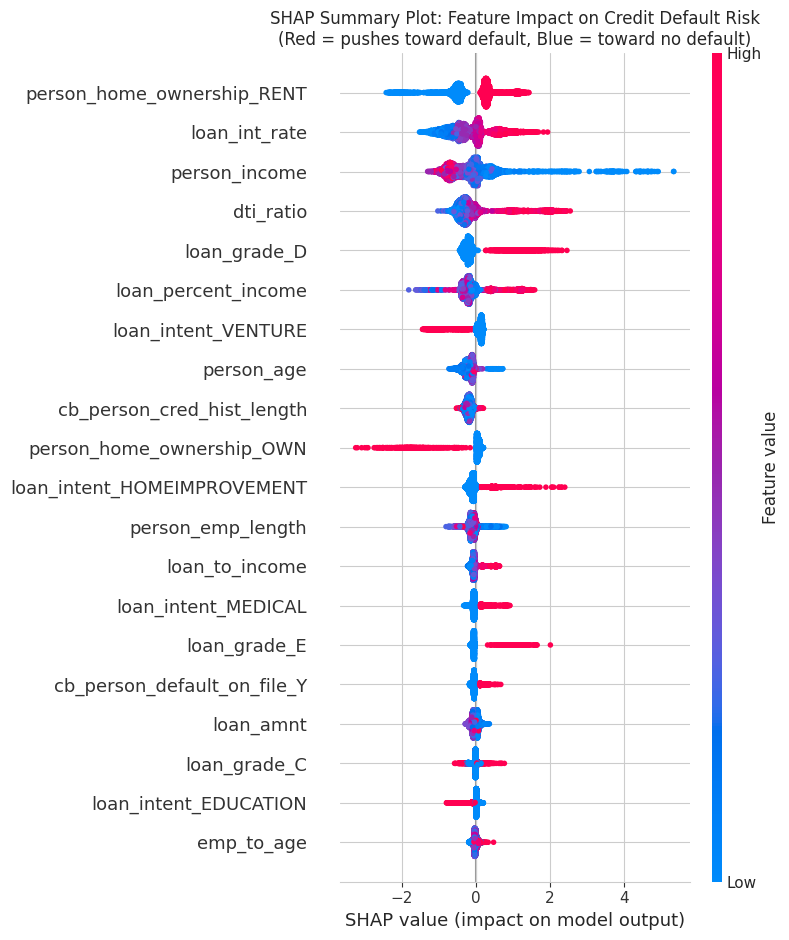

In [48]:
# 1. Summary plot (beeswarm) – Shows overall feature importance and direction of impact.

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary Plot: Feature Impact on Credit Default Risk\n(Red = pushes toward default, Blue = toward no default)")
plt.tight_layout()
plt.show()

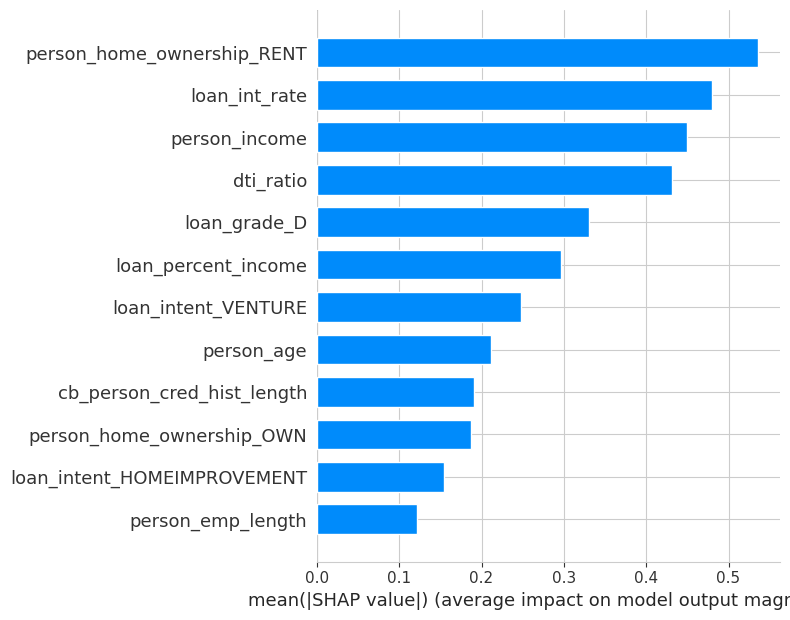

In [49]:
# 2. Bar version (cleaner for reports)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=12)

- Horizontal position: Average impact on prediction (higher = more important).
Color: Feature value (red = high value pushes risk up, blue = low value pushes risk down).
- Expect loan_grade_D, loan_to_income, dti_ratio, person_home_ownership_RENT to be at the top.
- Red dots on right for high-risk grades → "High loan grade strongly increases default probability".

3. Waterfall Plot for a Single High-Risk Example (Local Explainability)

### Local Example: Why This Applicant Was Flagged High-Risk

Example 5896: Predicted default prob = 99.9%


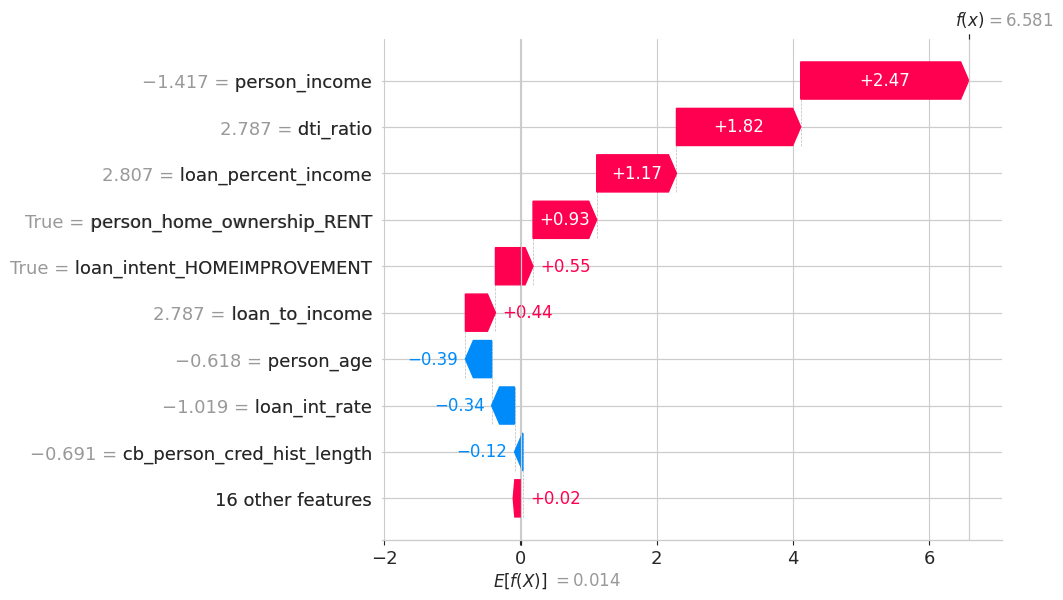

In [51]:
# Find a high-risk prediction (e.g., top 10% riskiest in test set)
y_prob = xgb.predict_proba(X_test)[:, 1]
high_risk_idx = np.argsort(y_prob)[-5]  # 5th highest risk example (change index as needed)

print(f"Example {high_risk_idx}: Predicted default prob = {y_prob[high_risk_idx]:.1%}")

# Waterfall plot for that instance
shap.plots.waterfall(shap.Explanation(
    values=shap_values[high_risk_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[high_risk_idx],
    feature_names=X_test.columns.tolist()
))

# Saving the Model, Scaler and Explainer for Streamlit app purposes

In [52]:
import joblib
import shap

# Save XGBoost model
joblib.dump(xgb, 'xgboost_credit_risk_model.pkl')

# Save scaler (used in preprocessing)
joblib.dump(scaler, 'scaler.pkl')

# Save explainer (for SHAP in app)
joblib.dump(explainer, 'shap_explainer.pkl')

print("Assets saved for Streamlit!")

Assets saved for Streamlit!
